# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Yue Xu   
**Partner:** Tianlun Luo    
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import time
from scipy import ndimage, misc
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

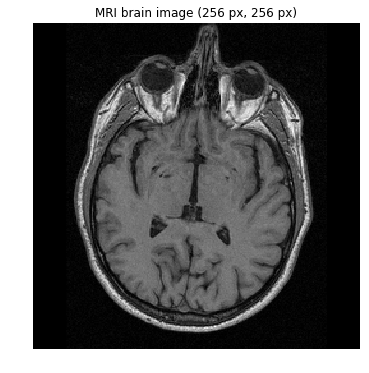

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

Implementation:

For the method of region growing, the approach is to examine neighboring pixels of an initial seed point and determines whether the pixel neighbors should be added to the region. A critereon or a simimlarity measure determines wether a neighboring pixel should be included in the region, and this implementation uses the intensity of pixels. If the difference between the intensity of a neighboring pixel and the mean intensity of the region is greater than a threshold, then we will not include the pixel, else, we will include it and update the mean intensity of the region. This method is an iterative process and the implementation below uses 4th connectivity, which means for each iteration, the left, right, top, and bottom pixels are considered. The function simple_region_growing() takes in the original image, a seed value, and threshold, and it returns an image where the pixel that is part of the region is shown in white. The code is adapted from http://www.lengrand.fr/2011/11/simple-region-growing-implementation-in-python

Results:

We chose an intial seed value of (100, 100) since we can tell that pixel is a part of the brain. We observe that the final area of the brain varys greatly depending on the threshold. A higher threshold is a more relaxed criteron. As you can see in the execution of the code below, a threshold of 5 results in an area of 158 pixels and is not a good representation of the brain, a threshold of 10 results in an area of 13413 pixels, a threshold of 15 results in an area of 16076 pixels, and a threshold of 20 results in an area of 17513 pixels. However, there is not much difference to the human eye between a threshold of 10, 15, and 20. 

Overall, region growing provides a good representation of the brain, but this method seems to have a high computational complexity, with a run time of 86.3 seconds. This might be due to the fact that this method is a local method and has no global view of the image, and is dependent of the intial seed value and threshold value.


In [3]:
def simple_region_growing(img, seed, threshold=1):
  
    dims = img.shape
    reg = np.zeros(dims)

    #parameters
    mean_reg = float(img[seed[1], seed[0]])
    size = 1
    pix_area = dims[0]*dims[1]

    contour = [] # will be [ [[x1, y1], val1],..., [[xn, yn], valn] ]
    contour_val = []
    dist = 0
    orient = [(1, 0), (0, 1), (-1, 0), (0, -1)] # 4 connectivity
    cur_pix = [seed[0], seed[1]]

    #Spreading
    while(dist<threshold and size<pix_area):
    #adding pixels
        for j in range(4):
            #select new candidate
            temp_pix = [cur_pix[0] +orient[j][0], cur_pix[1] +orient[j][1]]

            #check if it belongs to the image
            is_in_img = dims[0]>temp_pix[0]>0 and dims[1]>temp_pix[1]>0 #returns boolean
            #candidate is taken if not already selected before
            if (is_in_img and (reg[temp_pix[1], temp_pix[0]]==0)):
                contour.append(temp_pix)
                contour_val.append(img[temp_pix[1], temp_pix[0]] )
                reg[temp_pix[1], temp_pix[0]] = 150
        #add the nearest pixel of the contour in it
        dist = abs(int(np.mean(contour_val)) - mean_reg)

        dist_list = [abs(i - mean_reg) for i in contour_val ]
        dist = min(dist_list)    #get min distance
        index = dist_list.index(min(dist_list)) #mean distance index
        size += 1 # updating region size
        reg[cur_pix[1], cur_pix[0]] = 255

        #updating mean MUST BE FLOAT
        mean_reg = (mean_reg*size + float(contour_val[index]))/(size+1)
        #updating seed
        cur_pix = contour[index]

        #removing pixel from neigborhood
        del contour[index]
        del contour_val[index]

    return reg

Area is: 158


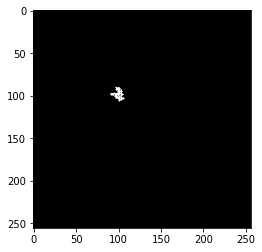

In [7]:
#threadhold = 5
seed = (100, 100)
test1 = simple_region_growing(brain_im, seed, 5)
plt.imshow(test1, cmap='gray')
print("Area is:", np.count_nonzero(test1))

Area is: 13413


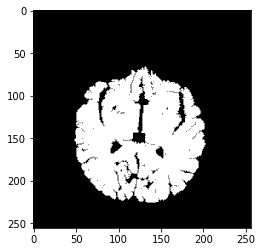

In [8]:
#threadhold = 10
test2 = simple_region_growing(brain_im, seed, 10)
plt.imshow(test, cmap='gray')
print("Area is:", np.count_nonzero(test2))

Area is: 16076


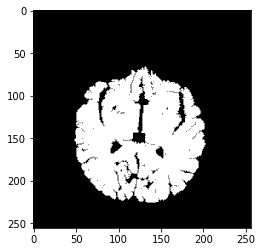

In [9]:
#threadhold = 15
test3 = simple_region_growing(brain_im, seed, 15)
plt.imshow(test, cmap='gray')
print("Area is:", np.count_nonzero(test3))

Area is: 17513
Time is: 86.33534622192383


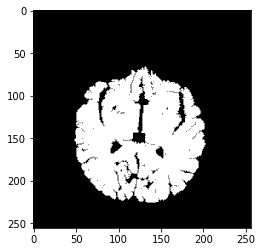

In [12]:
#threadhold = 20
start = time.time()
test4 = simple_region_growing(brain_im, seed, 20)
end = time. time()
plt.imshow(test, cmap='gray')
print("Area is:", np.count_nonzero(test4))
print("Time is:", end - start)

### 1.3 Contour detection
Add your implementation and discussion

Implementation:

For contour detection, we tried a variety of pre procesing methods before finding the contours that segments the brain. The main idea is to threshold the image such that there exist contour that decribes the brain. Then we use open cv function cv.findContours() to detect all contours (list of points) of white objects from a black back ground. We then sort all the contours by order of decreasing area. This means that the brain is defined by the first contour in the contour array returned by the cv.findContours() function. From post processing, we can also identify contours that defines an area inside the contour of the brain that does not belong to the brain. We would then remove the area that identifies these "holes" in the brain. We would also add the area of a small piece of brain in the lower left side that has its own contour. Finally, the final area is the areas that define the brain minus the area of the "holes" in the brain contour. 

Results:

First we tried a simple binary threshold before finding the contours and the area (method 1). A min threshold of 69 is necessay to isolate the chunk of brain from the skull. A max thresh of 100 is set so that the contour is visible when we overlay them when drawing. The final brain region is high lighted in yellow in the output results below. We found with just thresholding and contouring, the area is 11649.5 pixels. This result is much less than region growing, and we observed noisy ridges of the contour. In order to smooth the rough edges, we applied a medium filter before thresholding (method 2). The resulting area increases to 11780.0 and we observed that the contour of the brain is much smoother. Next, we tried applying an openning, then threshold, then finding the contour to see if we can segment a more volumnous brain (method 3). We created an eclipse structuring element of mask (3, 3) and applied the opening with cv.morphologyEx(). However, the resulting area was 10831.5 pixels, which was not ideal and included bits of the skull, although it is still smoother than method 1. So now, we realized that the thesholding that isolate the brain contour is very restricting, since the upper right eye of the skull is somewhat connect to the brain, so a threshold of 69 would lose the outer border of the brain in order to create the clear separation. For this reason, we tried to erode the upper right section of the brain before thresholding, specifically erode in the range of [50:90, 150:180] of the original image (method 4). With eroding first, we were able to set a lower threshold of 64, which is able to capture a more volumnous brain. This implementation results in an area of 13820.0 pixels, which seems to be able to segment a smooth and complete brain. 

Overall, we believe that method 4 created the best segmented brain with contouring, with is area comparable to region growing. A huge improvement from region growing is the time complexity, with the totla processing time decreaed from 86.3 seconds to 0.0238 seconds. However, this method does need preprocessing of erosion and applying medium blur, which needs human knowledge of the image, as well as post prcessing of subtracting the contour areas that represents the "holes".



#### Method 1: Threshold + contour 

Area is: 11649.5


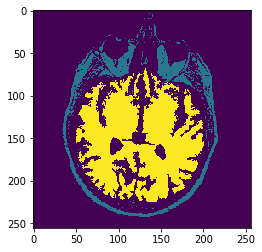

In [96]:
#Apply binary threshold
flag, thresh_img = cv.threshold(brain_im, 69, 100, cv.THRESH_BINARY)
#Find all contours
im2, contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#Sort contour from largest area to smallest area
contours = sorted(contours, key=cv.contourArea, reverse=True) 

#Extract area of contour that defines brain and subtract "holes"
a = cv.drawContours(thresh_img, contours, 0, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 4, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 5, (0, 0, 0), -1)
a = cv.drawContours(thresh_img, contours, 6, (0, 0, 0), -1)

plt.imshow(a)
print("Area is:", cv.contourArea(contours[0]) + cv.contourArea(contours[4]) - cv.contourArea(contours[5]) - cv.contourArea(contours[6]))

#### Method 2: Medium blur + threshold + contour

Area is: 11780.0


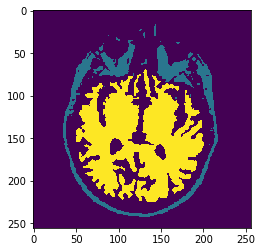

In [97]:
#Apply medium blur
blur = cv.medianBlur(brain_im, 3)
#Apply threshold
flag, thresh_img = cv.threshold(blur, 69, 100, cv.THRESH_BINARY)
im2, contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True) 

a = cv.drawContours(thresh_img, contours, 0, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 4, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 9, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 5, (0, 0, 0), -1)
a = cv.drawContours(thresh_img, contours, 6, (0, 0, 0), -1)

plt.imshow(a)
print("Area is:", cv.contourArea(contours[0]) + cv.contourArea(contours[4]) + cv.contourArea(contours[9]) - cv.contourArea(contours[5]) - cv.contourArea(contours[6]))

#### Method 3: Opening (first erode, then dilate) + threshold + contour

Area is: 10831.5


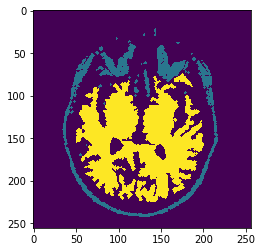

In [98]:
#Apply opening with ellipse structuring element 
element = cv.getStructuringElement(cv.MORPH_ELLIPSE , (3,3))
opening = cv.morphologyEx(brain_im, cv.MORPH_OPEN, element)
flag, thresh_img = cv.threshold(opening, 69, 100, cv.THRESH_BINARY)
im2, contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True) 

a = cv.drawContours(thresh_img, contours, 0, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 4, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 7, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 5, (0, 0, 0), -1)
a = cv.drawContours(thresh_img, contours, 6, (0, 0, 0), -1)

plt.imshow(a)
print("Area is:", cv.contourArea(contours[0]) + cv.contourArea(contours[4]) + cv.contourArea(contours[7]) - cv.contourArea(contours[5]) - cv.contourArea(contours[6]))

#### Method 4: Medium blur + threshold + erode upper right + contour

Area is: 13820.0
Time is: 0.02384209632873535


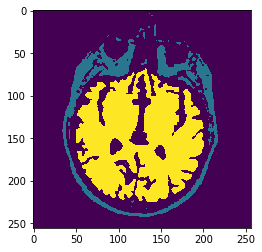

In [67]:
start = time.time()
#Medium blur
blur = cv.medianBlur(brain_im, 3)
#Threshold
flag, thresh_img = cv.threshold(blur, 64, 100, cv.THRESH_BINARY)

#Erode upper right corver of brain and skull intersection
kernel = np.ones((5,5),np.uint8)
sec = thresh_img[50:90, 150:180]
sec[:] = cv.erode(sec,kernel,iterations = 1)

im2, contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True) 

a = cv.drawContours(thresh_img, contours, 0, (255, 255, 0), -1)
a = cv.drawContours(thresh_img, contours, 2, (0, 0, 0), -1)
a = cv.drawContours(thresh_img, contours, 3, (0, 0, 0), -1)
a = cv.drawContours(thresh_img, contours, 4, (0, 0, 0), -1)

plt.imshow(a)
print("Area is:", cv.contourArea(contours[0]) - cv.contourArea(contours[2]) - cv.contourArea(contours[3]) - cv.contourArea(contours[4]))
end = time.time()
print("Time is:", end - start)

### 1.4 Additional method(s)
Add your implementation and discussion

For additional methods, we were able to segment the brain using connected components. First we erode the upper right corner, then we do a binary threshold, and then we find all the connected components with cv.connectedComponents(). Then in order to find the area of the brain, I find the component with the largest area. This method yields an area of 16166 pixels, which is comparable to the method of region growing, and much larger than results from contouring. This method is better than contouring because it does not need to post process the image by needing to subtract the areas of certain contours within the largest contour. Furthermore, the run time of connected components is much faster than region growing, with a run time of 0.023 seconds. The drawback would be the human preprocessing of finding the right area to erode as well as a threshold that would isolate the brain as an individual connected component. 

Below, we also included additional methods that did not work as we hoped, and provided the problems that we incountered.

1. Laplace of Gaussian: we hoped to detected the edges in the image by first applying a Gaussian blur (cv.GaussianBlur) followed by finding the second derivative using the Laplacian (cv.Laplacian). Then we wanted to find the zero crossing, and see if we can define a contour with a set of points that defines the contour of the brain. However, as shown in the ouput image of the zero crossings, there is so much noise in the back ground, even after a Guassian Blur, so we gave up on this method.
2. Sobel: we hoped to again use edge detection and then find the set of points that define the contour of the brain, but this time use Sobel algorithm, which is the first derivative, so we thought that this would be less noisy than Laplace of Gaussian. After finding the gradient in the x and y direction, we calculated the magnitude of the gradient. We then restricted the original image with pixels that has a gradient magnitude between 500 and 800, since we thought that the edge that defines the skull's change will be much greather than the change that transitions to the brian. However, even after trying to remove noise by first applying an opening of a larger mask and a closing of a smaller mask, pieces of the skull still remains. 
3. Active contouring: we tried to use open cv's active_contour function by tunning the parameters of alpha, beta, and gamma. The opencv active contour model introduces several energy terms, and when the sum of internal and external energy is minimal, we got the contour we want, so what the algorithm do is actually updates the snake in order to minimize its total energy. From the source code, the energy is defined as ENERGY = alpha * Econt + beta * Ecurv + gamma * Eimg. So alpha defines weight of continuity energy, beta defines weight of curvature energy, and gamma defines weight of image energy. We tried experimenting with different starting position of the curve indicated in red as well as playing around with different values of alpha, beta, and gamma. For example, we want to contour to not be very smooth since the actual contour of the brain is very rough and has concavity. So we tried decreasing the value of beta, but the final contour does not fit the brain well. 

### Connected Components

Area is: 16166
Time is: 0.022861003875732422


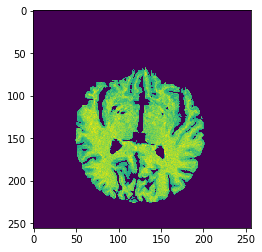

In [86]:
start = time.time()

#Threshold
flag, thresh_img = cv.threshold(brain_im, 53, 100, cv.THRESH_BINARY)

#Erode upper right corver of brain and skull intersection
kernel = np.ones((5,5),np.uint8)
sec = thresh_img[50:90, 150:180]
sec[:] = cv.erode(sec,kernel,iterations = 1)

ret, markers = cv.connectedComponents(thresh_img)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1                         
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = brain_im.copy()
brain_out[brain_mask==False] = 0

plt.imshow(brain_out)
print("Area is:", marker_area[largest_component - 1])
end = time.time()
print("Time is:", end - start)

#### Laplace of Gaussian (second derivative)

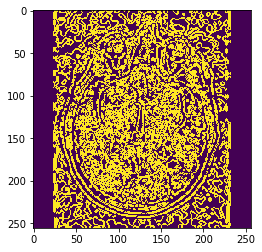

In [91]:
img = brain_im
img = cv.medianBlur(img, 5)
g = cv.GaussianBlur(img,(7,7),0)
LoG = cv.Laplacian(g, cv.CV_16S)
plt.imshow(LoG)
minLoG = cv.morphologyEx(LoG, cv.MORPH_ERODE, np.ones((3,3)))
maxLoG = cv.morphologyEx(LoG, cv.MORPH_DILATE, np.ones((3,3)))
zeroCross = np.logical_or(np.logical_and(minLoG < 0,  LoG > 0), np.logical_and(maxLoG > 0, LoG < 0))
plt.imshow(zeroCross)


#### Sobel (first derivative)

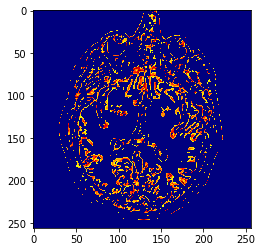

In [94]:
img = brain_im
#Guassian Blur
img = cv.GaussianBlur(img, (7,7), 1)
#get x and y first derivatives
grad_x = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
grad_y = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
#get gradient magnitutes
grad_mag = np.sqrt(np.add(np.multiply(grad_x, grad_x), np.multiply(grad_y, grad_y)))

#filtering by gradient magnitudes
th_grad_img = grad_mag
th_grad_img[th_grad_img < 500] = 0
th_grad_img[th_grad_img > 800] = 0

#removing noise using an opening and then a closing
se1 = cv.getStructuringElement(cv.MORPH_ELLIPSE , (3,3))
se2 = cv.getStructuringElement(cv.MORPH_ELLIPSE , (2,2))
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, se1)
mask = cv.morphologyEx(th_grad_img, cv.MORPH_CLOSE, se2)

plt.imshow(mask,cmap='jet')

#### Active Contour

[0, 256, 256, 0]

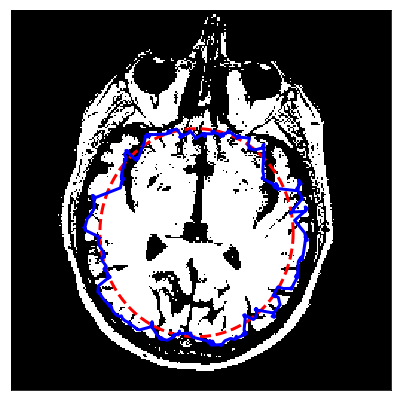

In [175]:
img = brain_im
img = rgb2gray(img)
flag, img = cv.threshold(img, 63, 75, cv.THRESH_BINARY)

s = np.linspace(0, 2*np.pi, 400)
x = 125 + 65*np.cos(s)
y = 150 + 70*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.00015, beta=0.000001, gamma=0.0001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [4]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


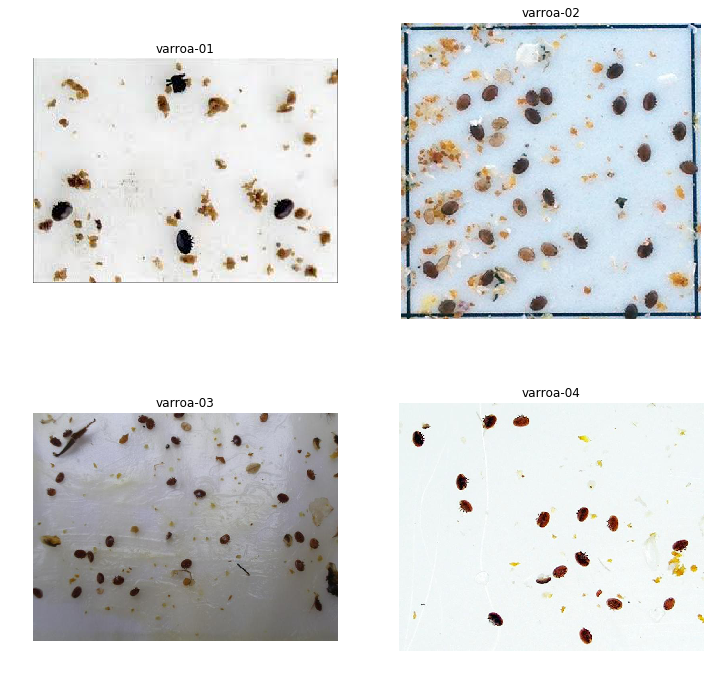

In [219]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [5]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [6]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]
print(annotations_xmls[0])

[{'name': 'Varroa', 'bbox': [14, 117, 19, 20]}, {'name': 'Varroa', 'bbox': [204, 117, 19, 20]}, {'name': 'Varroa', 'bbox': [123, 153, 13, 11]}]


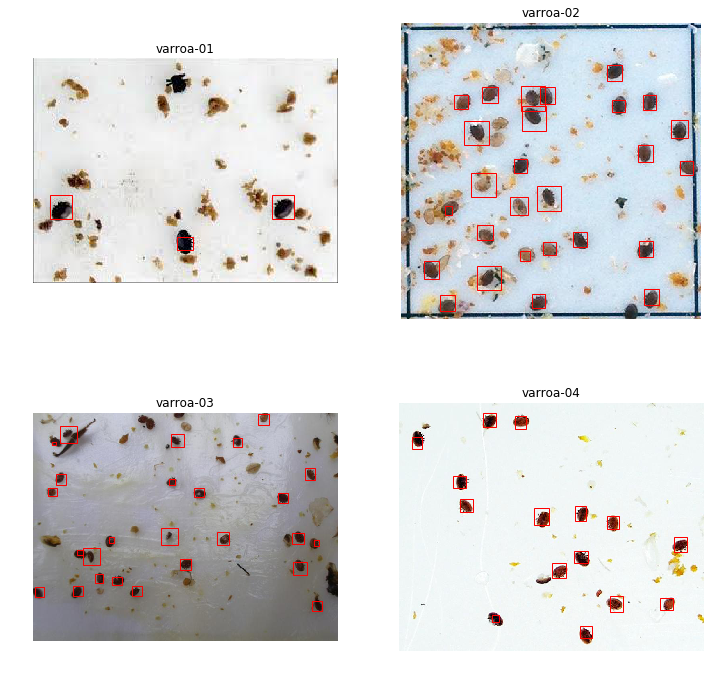

In [222]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Hint: `skimage.measure.label` might be useful to label the thresholded image

### Discussion

In our implementation, we first preprocess each image by apply a median blur to it. We noticed that the Varroa are generally darker than the other objects in the image. By applying a medium blur, we are effectively surpressing the lighter objects in the image, making them even lighter, while keeping the darker objects still relatively dark so that there is a bigger contrast between the Varroa and the other objects, making it easier for us to threshold the image later. To implement the median filter, we made use of the medianBlur function from the OpenCV library. After performing some parameter tuning, we found that the median filter works the best with a 15 x 15 filter. 

After applying the median filter, we thresholded the image to get a binary image such that a pixel is 1 if the cooresponding pixel from the filtered image is below a certain threshold and 0 otherwise. We then use the function skimage.measure.label with our binary image to find the number of components in the thresholded image, which corresponds to the number of Varroa in that image. We have found that a threshold between 0 and 80 works the best and we found that there are 4, 24, 34, and 16 Varroa in images 1, 2, 3, and 4 respectively.

The implemntation described above gave us the best accuracy, while we attempted other methods as well, they did not result in additional improvements. We have provided the code for these methods below, commented out.

We attempted to apply histogram equalization to each image in order to increase the contrast between the Varroa and the other objects. This method does not work very well since images 1, 2, and 4 already have big enough contrast between the Varroa and the other objects, doing a histogram equalization emphasized unnecessary details in the image, which made the accuracy worse. Since image 3 has a small foreground-to-background constrast, we did see an increase in contrast after the histogram equalization, however, this did not increase the accuracy on counting the number of Varroa. 

We also to tried to increase the contrast by brightening up the background of each image. Specifically, we first apply thresholding to identify the background of the image, then for the pixels that we identify as background, we manually set it to a bright white color. However, this did not increase or decrease our accuracy. 

Furthermore, we tried applying a Gaussian filter instead of a median filter to preprocess the original image, but it did not work as well as the median filter. We tried applying erosion to the thresholded image objects that are closed to each other may be joined together after the blur and we want to seqarate them again, but the erosion did not improve our accuracy.

While implementing the different methods, we came across the blob detector functionaility from OpenCV. The blob detector is able to detect the "blobs" in an image based on the area, circularity, convexity, and intertia ratio of the blobs that we want to detect. We tried to use the blob detector along with the preprocessing techniques such as blurring and background enhancement described above. The blob detector (code provided below) gave us a similar accuracy as our thresholding implementation. Since the blob detector implements advanced features that are out of the scope of this class, we decided to stick with our thresholding implementation.


In [7]:
actual_varroa_count = []
print("Ground truth:")
j = 1
for i in annotations_xmls: 
    print("Number of Varroa in image", j, ":", len(i))
    j += 1
    actual_varroa_count.append(len(i))
    
actual_varroa_count = np.array(actual_varroa_count)

Ground truth:
Number of Varroa in image 1 : 3
Number of Varroa in image 2 : 27
Number of Varroa in image 3 : 26
Number of Varroa in image 4 : 15


In [8]:
# histogram equalization for colored image
# borrowed from source: https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def equalize_hist(img):
    for c in range(0, 2):
        img[:,:,c] = cv.equalizeHist(img[:,:,c])

    cv.imshow('Histogram equalized', img)
    cv.waitKey(0)

    return img

# threshold the image
def thresh(image, th1, th2): 
    return cv.inRange(image, th1, th2)

Number of Varroa detected in image 1 : 4
Number of Varroa detected in image 2 : 24
Number of Varroa detected in image 3 : 34
Number of Varroa detected in image 4 : 16


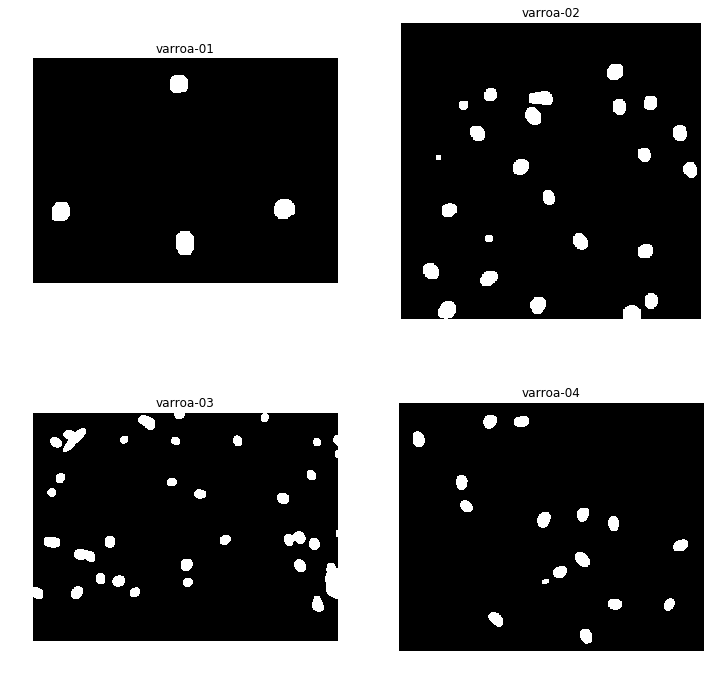

In [9]:
th1_bee = 0
th2_bee = 80

labeled_images = []
num_detected = []

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

i = 1
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    
# Perform histogram equalization
################################################################################
#     img_y_cr_cb = cv.cvtColor(im, cv.COLOR_BGR2YCrCb)
#     y, cr, cb = cv.split(img_y_cr_cb)

#     # Applying equalize Hist operation on Y channel.
#     y_eq = cv.equalizeHist(y)

#     img_y_cr_cb_eq = cv.merge((y_eq, cr, cb))
#     new_image = cv.cvtColor(img_y_cr_cb_eq, cv.COLOR_YCR_CB2BGR)
#     ax.imshow(new_image)
    
# Enhance the background by doing thresholding for the background
#################################################################################
#     background_th = 300
#     img_sum = np.sum(im, axis=2)
#     new_image = im.copy()
    
#     white = np.full((im.shape[0], im.shape[1]), 200)
#     new_image[:,:,0] = np.where(img_sum <= background_th, im[:,:,0], white)
#     new_image[:,:,1] = np.where(img_sum <= background_th, im[:,:,1], white)
#     new_image[:,:,2] = np.where(img_sum <= background_th, im[:,:,2], white)

#    ax.imshow(new_image)
    # print(new_image)

#################################################################################
    
    # apply thresholding
    gray_img = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    kernel = np.ones((6,6),np.uint8)
    blur = cv.medianBlur(gray_img, 15)
    blur = cv.erode(blur, kernel, iterations = 1)
    thresh_img = thresh(blur, th1_bee, th2_bee)   
    label_img, num_components = skimage.measure.label(thresh_img, connectivity=2, return_num=True)
    
    print("Number of Varroa detected in image", i, ":", num_components)
    i += 1
    
    num_detected.append(num_components)
    
    labeled_images.append(label_img)
    
    ax.imshow(thresh_img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
plt.show()




Number of Varroa detected in image 1 : 3
Number of Varroa detected in image 2 : 20
Number of Varroa detected in image 3 : 23
Number of Varroa detected in image 4 : 13


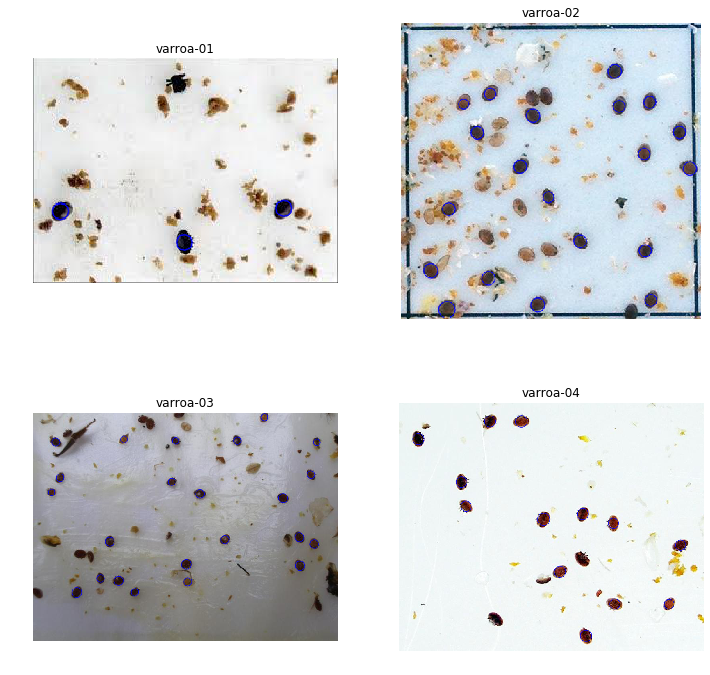

In [10]:
# Trying the blob detector...
# source: https://github.com/spmallick/learnopencv/blob/master/BlobDetector/blob.py
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
i = 1
for ax, im, nm in zip(axes.ravel(), ic, im_names):
# Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = 110

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 120

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8

    #Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.9

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.4

    # Create a detector with the parameters
    ver = (cv.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv.SimpleBlobDetector(params)
    else : 
        detector = cv.SimpleBlobDetector_create(params)
        
    background_th = 300
    img_sum = np.sum(im, axis=2)
    new_image = im.copy()
    
    white = np.full((im.shape[0], im.shape[1]), 200)
    new_image[:,:,0] = np.where(img_sum <= background_th, im[:,:,0], white)
    new_image[:,:,1] = np.where(img_sum <= background_th, im[:,:,1], white)
    new_image[:,:,2] = np.where(img_sum <= background_th, im[:,:,2], white)

    gray_img = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
    blur = cv.medianBlur(gray_img, 15)  
        
    keypoints = detector.detect(blur)
    lol = cv.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
    print("Number of Varroa detected in image", i, ":", len(keypoints))
    i += 1
        
    ax.imshow(lol)
    ax.axis('off')
    ax.set_title(nm)
    
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

### Discussion

To compute the IoU of the detected pattern, we first made use of the function skimage.measure.regiongroup to give us a set of bounding boxes that identifies the region of where each detected Varroa is, then we tried to match the set of bounding boxes with the set of bounding boxes provided by the ground truth using the brute force algorithm described in the FAQ section of section 2.1. Specifically, for every bounding box in the ground truth, we compute the IoU between it and every bounding box that we detected, the pair with the highest value of IoU would be the matching pair. To compute the IoU between two bounding boxes, we implemented the function iou(boxA, boxB) the calculates the IoU given two bounding boxes. Specifically, we first compute the area where the two boxes overlap, then compute the total area of the two bounding boxes, then subtract overlapping area from the total area to get the union area. Finally, dividing the overlapping area by the union area would give us the IoU We overlayed the detected bounding boxes on the original images below. Overall, we are getting IoU values around 0.5 to 0.6.

In [11]:
bboxes = skimage.measure.regionprops(labeled_images[0])
len(bboxes)

4

In [12]:
# function to find IoU
# modified from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def iou(boxA, boxB): 

    # x and y are flipped for ground truth bb and detected bb
    xA = max(boxA[0], boxB[1])
    yA = max(boxA[1], boxB[0])
    xB = min(boxA[2] + boxA[0], boxB[3])
    yB = min(boxA[3] + boxA[1], boxB[2])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

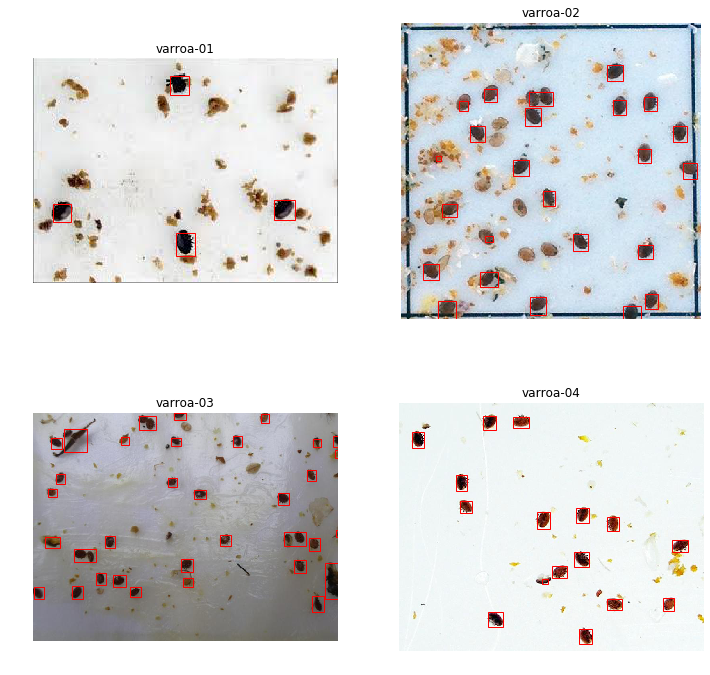

In [13]:
i = 0
j = 0

detected_pattern = []

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    
    bboxes = skimage.measure.regionprops(labeled_images[j])    
    detected_pattern.append(bboxes)
    
    j += 1
    for i in range(len(bboxes)):
        
        ymin = bboxes[i]['bbox'][0]
        xmin = bboxes[i]['bbox'][1]
        ymax = bboxes[i]['bbox'][2]
        xmax = bboxes[i]['bbox'][3]
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


In [14]:
detected = detected_pattern.copy()
ground_truth = annotations_xmls.copy()

print(len(detected))
print(len(ground_truth))

image_iou = []

4
4


In [15]:
# loop through each image
for i in range(4): 
    
    curr_detected = detected[i]
    curr_ground_truth = ground_truth[i]
    
    curr_image_ious = []
    
    # loop through each bounding box in the ground truth, trying to match each ground truth with a detected value
    for j in range(len(curr_ground_truth)): 
            
        # compute all possible iou value with the current ground truth, pick the largest IoU value as the matching pair
        del_idx = -1
        max_iou = -1
        
        visited = np.zeros(len(curr_detected))
        for k in range(len(curr_detected)): 
            
            if(visited[k] != 0): 
                continue
                
            curr_iou = iou(curr_ground_truth[j]['bbox'], curr_detected[k]['bbox'])
            if max_iou < curr_iou:
                
                max_iou = curr_iou
                del_idx = k        
        
        curr_image_ious.append(max_iou)    
        visited[del_idx] = 1

        if(len(curr_detected) <= 0): 
            break 
        
    
    image_iou.append(curr_image_ious)
        

In [16]:
print("IoU's for image 1:\n", image_iou[0], "\n")
print("IoU's for image 2:\n", image_iou[1], "\n")
print("IoU's for image 3:\n", image_iou[2], "\n")
print("IoU's for image 4:\n", image_iou[3], "\n")

print("Average IoU for image 1:", np.mean(image_iou[0]))
print("Average IoU for image 2:", np.mean(image_iou[1]))
print("Average IoU for image 3:", np.mean(image_iou[2]))
print("Average IoU for image 4:", np.mean(image_iou[3]))


IoU's for image 1:
 [0.505307855626327, 0.6710526315789473, 0.47058823529411764] 

IoU's for image 2:
 [0.475, 0.6785714285714286, 0.6722689075630253, 0.6012658227848101, 0.7035175879396985, 0.319672131147541, 0.4228094575799722, 0.7574850299401198, 0.5059523809523809, 0.72, 0.16991150442477876, 0.92, 0.6778242677824268, 0.6333333333333333, 0.4900990099009901, 0.0, 0.3861788617886179, 0.0, 0.0, 0.36363636363636365, 0.3685897435897436, 0.32253086419753085, 0.0, 0.408179012345679, 0.5, 0.3384615384615385, 0.46141975308641975] 

IoU's for image 3:
 [0.6784615384615384, 0.5460992907801419, 0.7964071856287425, 0.5675675675675675, 0.26262626262626265, 0.6608260325406758, 0.49122807017543857, 0.695054945054945, 0.6342943854324734, 0.7272727272727273, 0.646677471636953, 0.13043478260869565, 0.6185567010309279, 0.12173913043478261, 0.4846938775510204, 0.6535947712418301, 0.2808641975308642, 0.5947826086956521, 0.8333333333333334, 0.5714285714285714, 0.528, 0.4811320754716981, 0.4118050789293068

### 2.4 Precision, Recall and F1-score at two different IoU thresholds


### Discussion

We computed the precision, recall, and F1-score at two IoU thresholds for the 4 images using the formulas provided in section 2.1. Here we define a detected pattern as a true positive if it IoU w.r.t the ground truth is greater than the threshold; we define a detected pattern as false positive if its IoU w.r.t the ground truth is less than the threshold; and we define the false negative as a pattern that exists in the ground truth but is not detected by our classifier, that is, we have false negatives only when we have detected less Varroa than the ground truth. Overall, we noticed that the bounding boxes provided by the ground truth don't identify the Varroa regions with very high precision, which results in more rooms for error.

In [17]:
T = 0.5
print("At IoU threshold = 0.5: \n")
for i in range(4): 
    
    # calculate precision
    above_thresh = np.where(np.array(image_iou[i]) > T)
    tp = len(above_thresh[0])
    fp = num_detected[i] - tp
    precision = tp / float(tp + fp)
    
    print("Precision for image", i+1, "is", precision)
    
    # calculate recall
    fn = max(0, actual_varroa_count[i] - num_detected[i])
    recall = tp / float(tp + fn)
    print("Recall for image", i+1, "is", recall)
    
    # calculate F1 score
    f1 = (2 * precision * recall) / (precision + recall)
    print("F1 score for image", i+1, "is", f1, "\n")

    

At IoU threshold = 0.5: 

Precision for image 1 is 0.5
Recall for image 1 is 1.0
F1 score for image 1 is 0.6666666666666666 

Precision for image 2 is 0.4166666666666667
Recall for image 2 is 0.7692307692307693
F1 score for image 2 is 0.5405405405405406 

Precision for image 3 is 0.4411764705882353
Recall for image 3 is 1.0
F1 score for image 3 is 0.6122448979591837 

Precision for image 4 is 0.875
Recall for image 4 is 1.0
F1 score for image 4 is 0.9333333333333333 



In [18]:
T = 0.9
print("At IoU threshold = 0.9: \n")
for i in range(4): 
    
    # calculate precision
    above_thresh = np.where(np.array(image_iou[i]) > T)
    tp = len(above_thresh[0])
    fp = num_detected[i] - tp
    precision = tp / float(tp + fp)
    
    print("Precision for image", i+1, "is", precision)
    
    # calculate recall
    fn = max(0, actual_varroa_count[i] - num_detected[i])
    recall = 0.0
    if tp != 0:
        recall = tp / float(tp + fn)
    print("Recall for image", i+1, "is", recall)
    
    # calculate F1 score
    f1 = 0.0
    if precision != 0 and recall != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    print("F1 score for image", i+1, "is", f1, "\n")

At IoU threshold = 0.9: 

Precision for image 1 is 0.0
Recall for image 1 is 0.0
F1 score for image 1 is 0.0 

Precision for image 2 is 0.041666666666666664
Recall for image 2 is 0.25
F1 score for image 2 is 0.07142857142857142 

Precision for image 3 is 0.0
Recall for image 3 is 0.0
F1 score for image 3 is 0.0 

Precision for image 4 is 0.0
Recall for image 4 is 0.0
F1 score for image 4 is 0.0 

